<a href="https://colab.research.google.com/github/Mainakdeb/e_summit/blob/main/predict_personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demostrates how our script works. Check out the main code here - https://github.com/Mainakdeb/e_summit


## Mount Google Drive to Access Pretrained Models

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install socialreaper version 0.3.0
Most of the dependencies needed are already available in colab, when running the script locally, make sure to run 
```
pip install -r requirements.txt
```

In [26]:
!pip3 install socialreaper==0.3.0

In [27]:
import optparse
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

from socialreaper import Twitter
from socialreaper.tools import to_csv

## Load the classifiers:

In [29]:
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from data_prep import DataPrep
from sklearn.feature_extraction.text import TfidfVectorizer

class Model():
    def __init__(self):
        self.rfr = RandomForestRegressor(bootstrap=True,
         max_features='sqrt',
         min_samples_leaf=1,
         min_samples_split=2,
         n_estimators= 200)
        self.rfc = RandomForestClassifier(max_features='sqrt', n_estimators=110)
        self.tfidf = TfidfVectorizer(stop_words='english', strip_accents='ascii')

    def fit(self, X, y, regression=True):
        X = self.tfidf.fit_transform(X)
        if regression:
            self.rfr = self.rfr.fit(X, y)
        else:
            self.rfc = self.rfc.fit(X, y)

    def predict(self, X, regression=True):
        X = self.tfidf.transform(X)
        if regression:
            return self.rfr.predict(X)
        else:
            return self.rfc.predict(X)

    def predict_proba(self, X, regression=False):
        X = self.tfidf.transform(X)
        if regression:
            raise ValueError('Cannot predict probabilites of a regression!')
        else:
            return self.rfc.predict_proba(X)

M = Model()
models={}
traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
for trait in traits:
    with open('/content/drive/MyDrive/mydata/big5_models/' + trait + '_model.pkl', 'rb') as f:
        models[trait] = pickle.load(f)

## Define get_profile( ):
the get_profile( ) function takes keywords/names as input and returns corresponding social media id's as a dictionary.

In [30]:
from googlesearch import search
import re

def get_profile(keyword):
  print("getting profiles from google..")
  results = list(search(keyword, num=10))
  profiles = {
      'twitter': ''
  }
  for r in results:
    if r.find('twitter') != -1 and profiles['twitter'] == '':
      r = re.search(r'https://twitter.com/([^/?]+)', r).group(1)
      profiles['twitter'] = r

  return profiles

## Define get_text_from_tweets( ) :
this function below takes the twitter username (string) as input, then gets rid of special characters using regex, and returns tweets corresponding to that user in form of a string. 

In the main script, we have saved the scraped tweets as information.txt to adhere with the problem statement.

In [31]:
twt = Twitter(app_key="PDz1fZLoCEHcOx035TtLsrcWS", 
              app_secret="Ok1aJBP4nM6g87F3hFiPFY0R0a7qnUNsdIoKZteaAuzYF2yTuF", 
              oauth_token="1292034807057149952-3Mlqa59ZAoqRdACgnW6z4goXUy3vUs", 
              oauth_token_secret="ZZlu7jF3mymeapDxwj19MkqCYF3osQjp48xYEuIL4wRM1")
    
def get_text_from_tweets(user_name):
    print("processing text from tweets..")
    tweets = twt.user(user_name, 
                    count=1000, 
                    exclude_replies=False, 
                    include_retweets=True)
        
    to_csv(list(tweets), filename=user_name+'_tweets.csv')

    tweets_df = pd.read_csv(user_name+"_tweets.csv")
    just_tweets=tweets_df[["text"]]
    ##remove urls 
    no_urls = just_tweets['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    #just_text_from_tweets.head(50)
    no_urls=no_urls.to_frame()

    # convert rows to a string
    tweets_string = ""
    for idx,row in no_urls.iterrows():
        tweets_string += (row['text'] + '. ')

    clean_text = re.sub("[^A-Za-z0-9. ]"," ",tweets_string)
    clean_text = clean_text.strip()
    return(clean_text)


## Define predict_personality( )
This function accepts a string as input and returns an array of floats, each corresponding to one of 5 personality traits.

In [32]:
def predict(X):
        X=[X]
        predictions = {}
        traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
        for trait in traits:
            pkl_model = models[trait]
            trait_scores = pkl_model.predict(X, regression=True).reshape(1, -1)
            # scaler = MinMaxScaler(feature_range=(0, 50))
            # print(scaler.fit_transform(trait_scores))
            # scaled_trait_scores = scaler.fit_transform(trait_scores)
            predictions['pred_s'+trait] = trait_scores.flatten()[0]
            # predictions['pred_s'+trait] = scaled_trait_scores.flatten()

            trait_categories = pkl_model.predict(X, regression=False)
            predictions['pred_c'+trait] = str(trait_categories[0])
            # predictions['pred_c'+trait] = trait_categories

            trait_categories_probs = pkl_model.predict_proba(X)
            predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1][0]
            # predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1]
        return predictions

## Define display_results( ):
This function plots a bar chart, representing each of the 5 OCEAN tendencies of the user.

In [33]:
def display_results(predictions, user_name):
    attrs = [predictions['pred_prob_cOPN'],
             predictions['pred_prob_cCON'],
             predictions['pred_prob_cEXT'],
             predictions['pred_prob_cAGR'],
             predictions['pred_prob_cNEU']]

    plt.rcParams["figure.figsize"] = (12, 6)
    #plt.style.use('ggplot')
    plt.ylim([0.0,1.0])
    plt.bar(['Openness','Conscientiousness','Extraverison','Agreeableness','Neuroticism'],attrs, color =('green', 'black', 'pink', 'orange', 'yellow'), alpha=0.5)
    plt.xlabel("Attribute")
    plt.ylabel("Tendency")
    plt.title(user_name+"'s Personality Report")
    plt.grid()
    plt.show()

##Moment of truth:
Feel free to replace Elon Musk with Chetan Bhagat, Ratan Tata etc.


In [34]:
user_name = get_profile("Elon Musk")['twitter']
text = get_text_from_tweets(user_name)
predictions = predict(text)
#display_results(predictions=predictions, user_name=user_name)

getting profiles from google..
processing text from tweets..


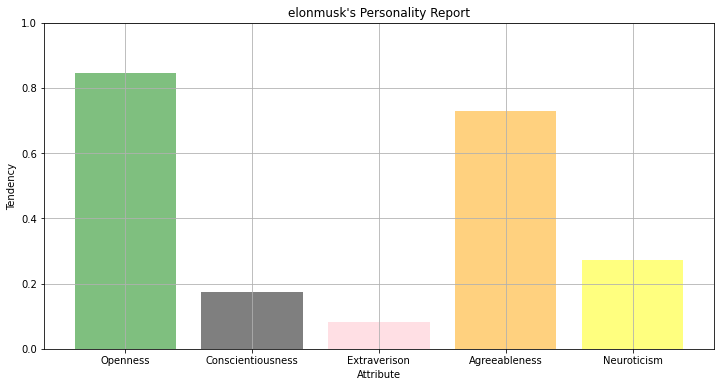

In [35]:
display_results(predictions=predictions, user_name=user_name)

The main script accepts a file names.txt, and generates 2 files, information.txt and predictions.txt

Do check out the main script - https://github.com/Mainakdeb/e_summit